In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import h5py
from cca.synth_data import gen_gp_kernel, sample_gp, embed_gp, gen_gp_cov
from cca.kron_pca import cv_toeplitz, form_lag_matrix, pv_rearrange, pv_rearrange_inv, toeplitzify
from cca.cov_util import calc_cov_from_cross_cov_mats
from cca.synth_data import gen_chaotic_rnn, gen_lorenz_system

In [2]:
def disp_cov(cov, title=None):
    scale = np.max(np.abs(cov))
    plt.imshow(cov, vmin=-scale, vmax=scale, cmap="RdGy")
    plt.colorbar()
    plt.title(title, fontsize=12)
    plt.show()
    
def regularize_cov(X, T_cov, cov_true):
    
    N = X.shape[1]
    X_with_lags = form_lag_matrix(X, T_cov)
    X_with_lags -= X_with_lags.mean(axis=0)
    cov_sample = np.dot(X_with_lags.T, X_with_lags)/len(X_with_lags)
    
    ll_vals, cov_reg = cv_toeplitz(X_with_lags, N, T_cov, num_folds=10, max_r=2*T_cov-1, small_eigval=1e-6)
    ll_mean = np.mean(ll_vals, axis=0)
    r_vals = np.arange(1, 2*T_cov)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    plt.subplots_adjust(hspace=0.3)
    ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

    ax1.plot(r_vals, ll_vals.T, c="black", linewidth=0.5)
    ax1.plot(r_vals, ll_vals.mean(axis=0), c="black", linewidth=4)
    ax1.set_xlabel("$r$ (num. factors)", fontsize=16)
    ax1.set_ylabel("log likelihood", fontsize=16)
    ax1.set_title("Cross validation", fontsize=16)
    r_opt = np.argmax(ll_vals.mean(axis=0))+1
    ax1.axvline(r_opt, c="red", label="$r_{opt}=$"+str(int(r_opt)))
    ax1.legend(frameon=False, fontsize=16)
    
    R = pv_rearrange(cov_true, N, T_cov)
    U, s, Vt = scipy.linalg.svd(R)
    s = s[:2*T_cov - 1]
    #ax2.set_yscale("log")
    ax2.scatter(np.arange(len(s))+1, s, s=30, color="black", zorder=1)
    ax2.axvline(r_opt, c="red", label="$r_{opt}=$"+str(int(r_opt)))
    ax2.set_title("Actual covariance SVs", fontsize=16)
    ax2.set_xlabel("$r$ (num. factors)", fontsize=16)
    ax2.set_ylabel("singular values")
    ax2.legend(frameon=False, fontsize=16)

    scale = np.max(np.abs(np.concatenate((cov_true.flatten(), cov_reg.flatten(), cov_sample.flatten()))))
    ax3.imshow(cov_true, vmin=-scale, vmax=scale, cmap="RdGy")
    ax3.set_title("Actual covariance", fontsize=16)

    ax4.imshow(cov_sample, vmin=-scale, vmax=scale, cmap="RdGy")
    ax4.set_title("Sample covariance", fontsize=16)

    ax5.imshow(cov_reg, vmin=-scale, vmax=scale, cmap="RdGy")
    ax5.set_title("Regularized covariance", fontsize=16)
    
    err_sample = (cov_true - cov_sample).flatten()
    err_reg = (cov_true - cov_reg).flatten()
    scale = np.max(np.abs(np.concatenate((err_sample, err_reg))))
    ax6.set_title("Elementwise errors", fontsize=16)
    ax6.hist(err_sample, range=(-scale, scale), color="black", bins=100, label="sample")
    ax6.hist(err_reg, range=(-scale, scale), color="red", alpha=0.75, bins=100, label="regularized")
    ax6.legend(fontsize=12, frameon=False)
    
    
    
    
    


1


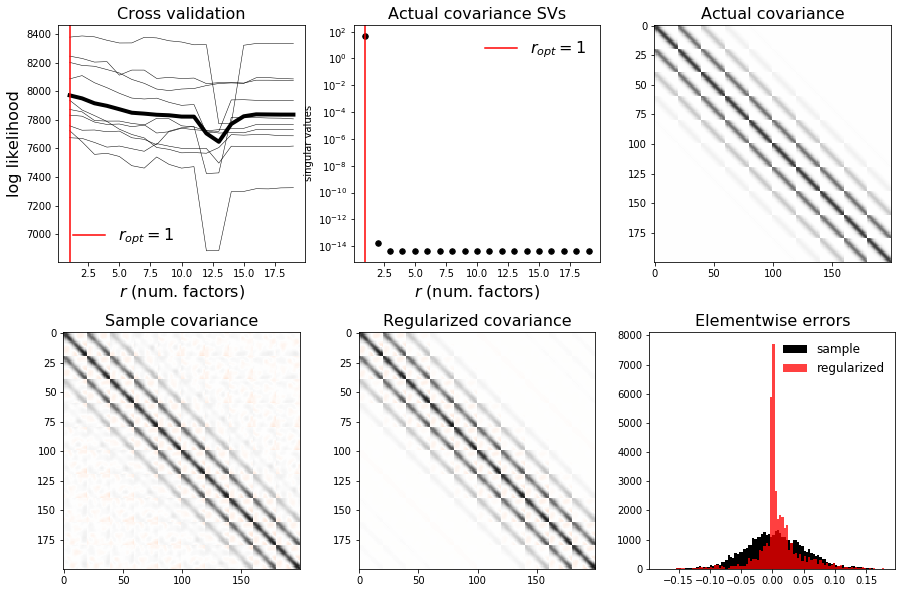

In [3]:
"""
Start out with simple test...
"""

N = 20
T_cov = 10

T_data = 100
num_to_concat = 10

K = gen_gp_kernel("squared_exp", spatial_scale=4, temporal_scale=2)
X = sample_gp(T_data, N, K, num_to_concat=num_to_concat)
cov_true = gen_gp_cov(T_cov, N, K)

regularize_cov(X, T_cov, cov_true)

2


'\nR_true = pv_rearrange(cov_true, N, T_cov)\nU, s, Vt = scipy.linalg.svd(R_true)\nplt.yscale("log")\nplt.scatter(np.arange(len(s))+1, s)\nplt.show()\n'

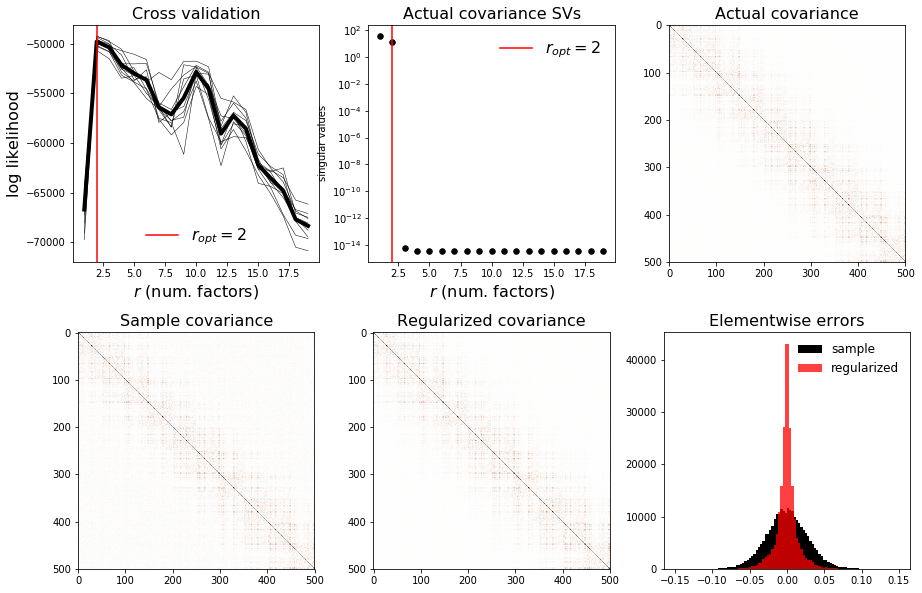

In [4]:
"""
Now sample a low-D GP, embedd it in high-D space, and add structured noise
"""

N = 50
d = 10
T_pi = 5
T_cov = T_pi*2

T_data = 100
num_to_concat = 10

K = gen_gp_kernel("squared_exp", spatial_scale=4, temporal_scale=2)

noise_dim = N/2
noise_variance = 2.5
noise_spectrum = noise_variance*np.exp(-np.arange(N)/(noise_dim/2))
noise_V = scipy.stats.ortho_group.rvs(N)
noise_cov = np.dot(noise_V, np.dot(np.diag(noise_spectrum), noise_V.T))

X, _, _, _, high_d_cross_cov_mats = embed_gp(T_data, N, d, K, noise_cov, T_pi, num_to_concat=num_to_concat)
cov_true = calc_cov_from_cross_cov_mats(high_d_cross_cov_mats)

regularize_cov(X, T_cov, cov_true)



"""
R_true = pv_rearrange(cov_true, N, T_cov)
U, s, Vt = scipy.linalg.svd(R_true)
plt.yscale("log")
plt.scatter(np.arange(len(s))+1, s)
plt.show()
"""

0
20
40
60
80
100
120


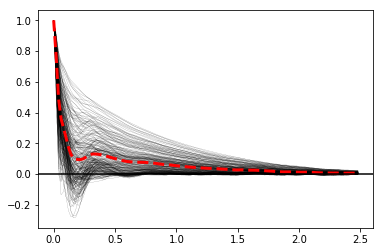

In [63]:
f = h5py.File("rnn_data.hdf5", "r")
skip = 5
X = f["data"][0:1000000:skip]
data_dt = f.attrs["dt"]*skip
N = X.shape[1]
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

#Visualize single-neuron autocorr. functions
max_dt = int(2.5 / data_dt)
corr_fns = np.zeros((N, max_dt))
for dt in range(max_dt):
    if dt % 20 == 0:
        print(dt)
    corr_fns[:, dt] = (X[dt:] * X[:len(X)-dt]).sum(axis=0)/(len(X)-dt)
    
t = np.arange(max_dt)*data_dt
plt.plot(t, corr_fns.T, linewidth=0.1, c="black")
plt.plot(t, corr_fns.mean(axis=0), linewidth=3, c="red", linestyle="--")
plt.axhline(0, c="black")

(133334, 250)
39


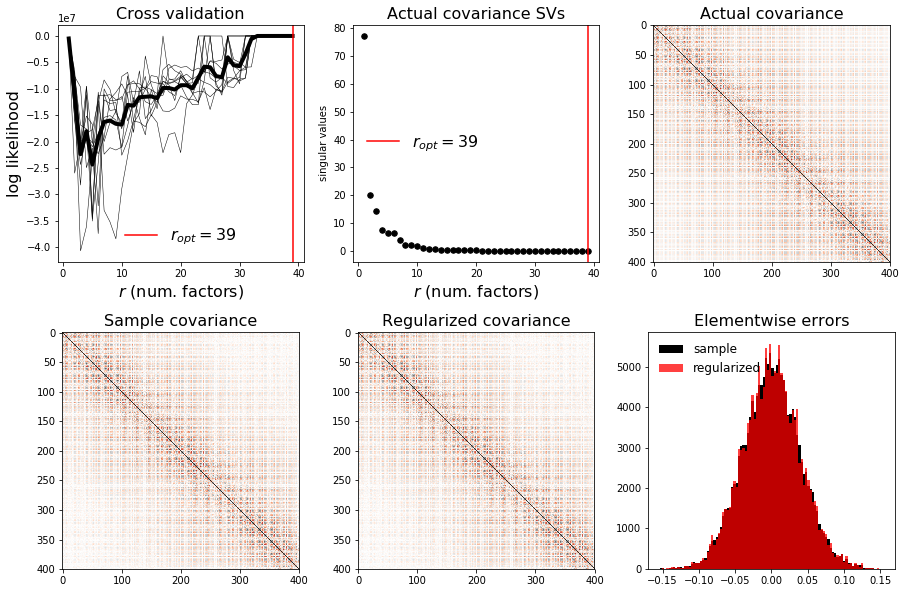

In [61]:
f = h5py.File("rnn_data.hdf5", "r")
skip = 15
X = f["data"][0:2000000:skip]
data_dt = f.attrs["dt"]*skip
N = X.shape[1]
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)
print(X.shape)

T_cov = 20
N = 20
X = X[:, :N]
X_with_lags = form_lag_matrix(X[1000:], T_cov)
cov_true = np.dot(X_with_lags.T, X_with_lags)/len(X_with_lags)

offset = 50000
X = X[:1000]

regularize_cov(X, T_cov, cov_true)

In [60]:
cov_toep = toeplitzify(cov_sample, N, T_cov)

In [65]:
R = pv_rearrange(cov_toep, N, T_cov)
U, s, Vt = scipy.linalg.svd(R, full_matrices=False)

In [30]:
f.close()

In [32]:
X.shape

(72000, 250)

In [23]:
f = h5py.File("rnn_data.hdf5", "r")
X = f["data"][2000000:2000000+200]

(array([   2.,   12.,    4.,   14.,   16.,   22.,   34.,   58.,   72.,
          76.,  108.,  142.,  134.,  216.,  234.,  296.,  312.,  404.,
         416.,  488.,  520.,  546.,  600.,  684.,  742.,  746.,  896.,
         956.,  898., 1058., 1060., 1186., 1202., 1188., 1320., 1262.,
        1310., 1376., 1398., 1462., 1452., 1400., 1442., 1538., 1530.,
        1516., 1540., 1522., 1402., 1338., 1336., 1426., 1410., 1342.,
        1316., 1254., 1240., 1188., 1208., 1138., 1020.,  992.,  874.,
         894.,  860.,  790.,  708.,  640.,  596.,  526.,  540.,  458.,
         408.,  360.,  294.,  248.,  210.,  198.,  124.,  136.,  106.,
          56.,   68.,   38.,   34.,   22.,   18.,   16.,    4.,    2.,
           2.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         250.]),
 array([-0.83033445, -0.81203111, -0.79372776, -0.77542442, -0.75712107,
        -0.73881773, -0.72051438, -0.70221104, -0.68390769, -0.66560435,
        -0.647301  , -0.62899766, -0.61069432, -0.592390

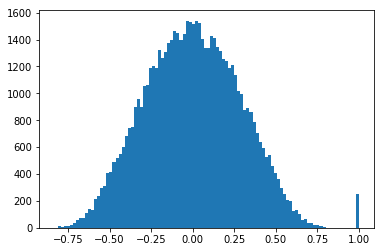

In [44]:
cov = np.dot(X.T, X)/len(X)
plt.hist(cov.flatten(), bins=100)

In [4]:
f = h5py.File("rnn_data.hdf5", "r")
skip = 100
X = f["data"][::skip]
data_dt = f.attrs["dt"]*skip

In [5]:
X.shape

(216000, 250)